In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# requires downloaded repo to gdrive
%cd /content/drive/MyDrive/attention-learn-to-route

/content/drive/MyDrive/attention-learn-to-route


In [4]:
!ls

environment.yml   LICENSE	  pretrained		  run.py
eval.py		  nets		  problems		  simple_tsp.ipynb
generate_data.py  options.py	  README.md		  train.py
images		  plot_vrp.ipynb  reinforce_baselines.py  utils


In [5]:
import os

In [6]:
os.getcwd()

'/content/drive/MyDrive/attention-learn-to-route'

In [7]:
import os
import numpy as np
import torch

In [8]:
from utils import load_model
model, _ = load_model('pretrained/tsp_100/')
model.eval()  # Put in evaluation mode to not track gradients

xy = np.random.rand(10, 2)

def make_oracle(model, xy, temperature=1.0):
    
    num_nodes = len(xy)
    
    xyt = torch.tensor(xy).float()[None]  # Add batch dimension
    
    with torch.no_grad():  # Inference only
        embeddings, _ = model.embedder(model._init_embed(xyt))

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        fixed = model._precompute(embeddings)
    
    def oracle(tour):
        with torch.no_grad():  # Inference only
            # Input tour with 0 based indices
            # Output vector with probabilities for locations not in tour
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                step_context = model.W_placeholder
            else:
                step_context = torch.cat((embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1)

            # Compute query = context node embedding, add batch and step dimensions (both 1)
            query = fixed.context_node_projected + model.project_step_context(step_context[None, None, :])

            # Create the mask and convert to bool depending on PyTorch version
            mask = torch.zeros(num_nodes, dtype=torch.uint8) > 0
            mask[tour] = 1
            mask = mask[None, None, :]  # Add batch and step dimension

            log_p, _ = model._one_to_many_logits(query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask)
            p = torch.softmax(log_p / temperature, -1)[0, 0]
            assert (p[tour] == 0).all()
            assert (p.sum() - 1).abs() < 1e-5
            #assert np.allclose(p.sum().item(), 1)
        return p.numpy()
    
    return oracle

  [*] Loading model from pretrained/tsp_100/epoch-99.pt


In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    



In [10]:
def run(xy):
  oracle = make_oracle(model, xy)

  sample = False
  tour = []
  tour_p = []
  while(len(tour) < len(xy)):
      p = oracle(tour)
      
      if sample:
          # Advertising the Gumbel-Max trick
          g = -np.log(-np.log(np.random.rand(*p.shape)))
          i = np.argmax(np.log(p) + g)
          # i = np.random.multinomial(1, p)
      else:
          # Greedy
          i = np.argmax(p)
      tour.append(i)
      tour_p.append(p)
      
  print(tour)
  fig, ax = plt.subplots(figsize=(10, 10))
  plot_tsp(xy, tour, ax)

[70, 59, 8, 99, 4, 1, 26, 10, 18, 97, 47, 82, 25, 49, 66, 89, 19, 92, 2, 14, 30, 71, 22, 32, 80, 55, 33, 77, 88, 6, 51, 28, 79, 20, 48, 36, 15, 81, 56, 96, 21, 13, 65, 52, 90, 93, 42, 86, 9, 61, 62, 63, 57, 91, 69, 41, 45, 84, 5, 12, 11, 43, 64, 72, 34, 16, 98, 60, 53, 46, 23, 37, 78, 31, 50, 83, 39, 74, 44, 29, 67, 3, 73, 27, 94, 95, 75, 85, 54, 17, 38, 40, 87, 24, 7, 0, 76, 35, 68, 58]


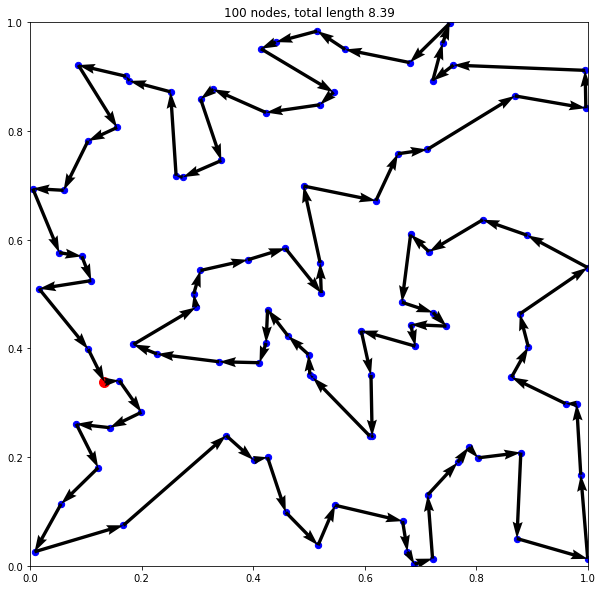

In [12]:
run(np.random.rand(100, 2))

[0, 3, 8, 7, 6, 5, 4, 2, 9, 1]


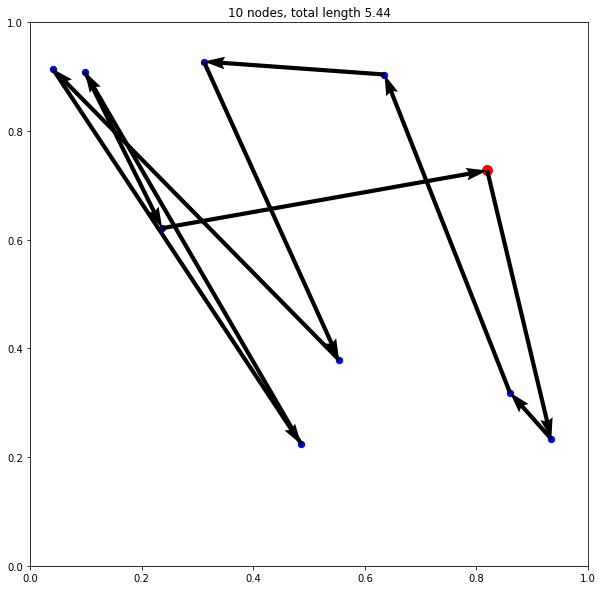

In [ ]:
run(np.random.rand(10, 2))

[48, 938, 96, 604, 186, 685, 552, 171, 551, 667, 483, 217, 465, 434, 863, 535, 630, 805, 910, 515, 150, 576, 242, 316, 876, 478, 332, 262, 741, 390, 285, 107, 68, 918, 875, 442, 985, 797, 713, 550, 504, 917, 901, 301, 266, 695, 358, 507, 872, 817, 978, 701, 14, 441, 163, 39, 260, 939, 932, 795, 432, 728, 175, 627, 229, 617, 216, 906, 559, 907, 353, 649, 352, 686, 971, 937, 689, 31, 475, 53, 506, 22, 484, 687, 783, 243, 723, 343, 64, 349, 779, 463, 290, 951, 908, 950, 505, 851, 892, 632, 774, 761, 758, 66, 429, 477, 173, 587, 523, 493, 801, 23, 815, 868, 764, 224, 287, 249, 397, 622, 427, 67, 833, 585, 21, 882, 320, 578, 211, 348, 841, 213, 379, 57, 936, 770, 781, 595, 603, 77, 425, 273, 145, 192, 188, 640, 437, 620, 921, 95, 278, 381, 347, 754, 449, 360, 769, 537, 486, 691, 459, 430, 83, 796, 889, 183, 557, 704, 279, 944, 452, 588, 284, 544, 553, 850, 51, 705, 76, 136, 46, 310, 342, 182, 767, 846, 618, 373, 877, 369, 331, 962, 81, 126, 421, 167, 495, 546, 410, 215, 574, 659, 445, 487, 

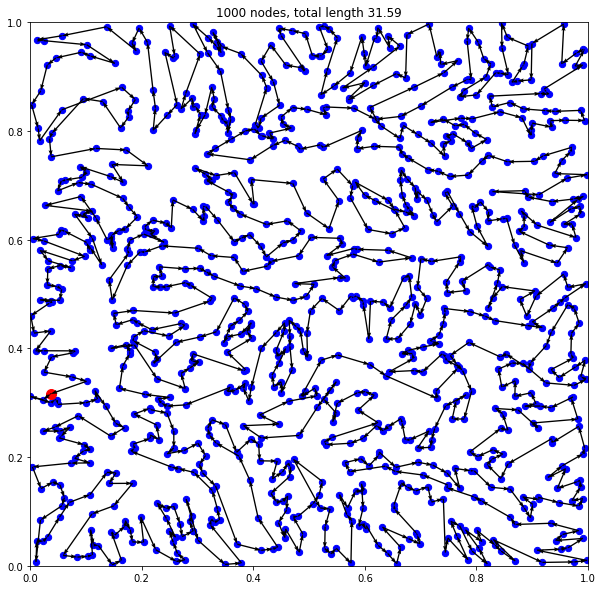

In [ ]:
run(np.random.rand(1000, 2))

[2, 7, 79, 94, 44, 29, 55, 1, 58, 71, 99, 64, 56, 75, 9, 80, 37, 30, 61, 69, 8, 89, 14, 96, 21, 84, 43, 90, 15, 38, 52, 19, 34, 16, 51, 42, 76, 60, 86, 59, 91, 18, 36, 20, 48, 66, 22, 93, 83, 39, 41, 11, 3, 88, 53, 73, 50, 10, 57, 47, 67, 26, 25, 70, 17, 5, 27, 78, 95, 77, 46, 45, 92, 0, 12, 97, 40, 33, 4, 82, 13, 98, 72, 81, 6, 28, 35, 54, 24, 63, 65, 31, 23, 85, 68, 87, 74, 62, 49, 32]


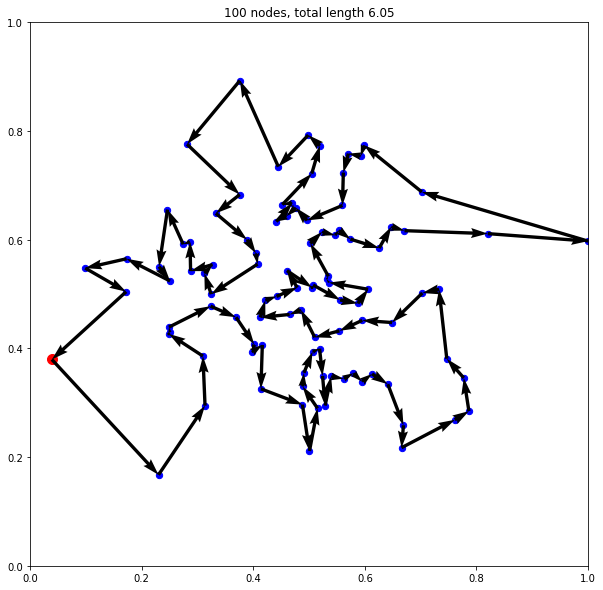

In [ ]:
N = 100
xy = np.clip(np.random.normal(0.5, 0.15, 2*N), 0, 1).reshape(N,2)
run(xy)

In [ ]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

[87, 62, 49, 32, 2, 7, 79, 44, 55, 29, 94, 1, 24, 74, 31, 63, 65, 58, 36, 71, 99, 64, 56, 75, 9, 80, 89, 37, 30, 8, 14, 96, 21, 84, 43, 90, 15, 38, 52, 19, 34, 16, 76, 60, 86, 69, 61, 59, 18, 91, 20, 48, 66, 22, 54, 35, 28, 81, 40, 97, 92, 45, 50, 73, 83, 93, 88, 3, 53, 39, 41, 11, 42, 51, 17, 70, 5, 25, 26, 67, 47, 10, 57, 46, 77, 78, 27, 95, 4, 82, 33, 13, 98, 72, 0, 12, 6, 68, 23, 85]


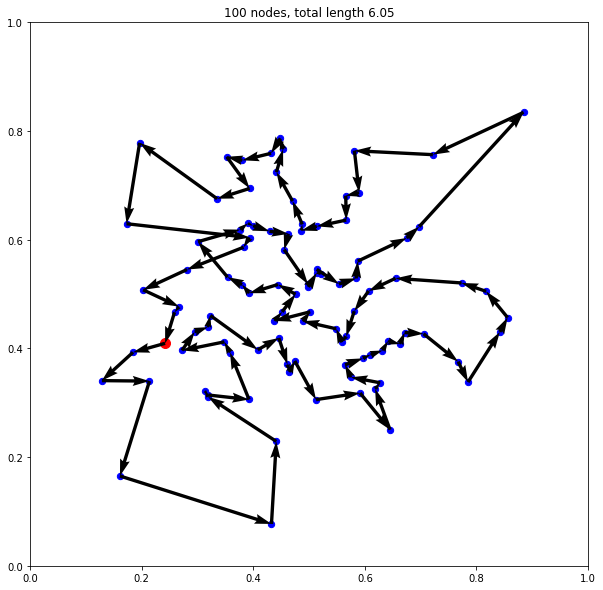

In [ ]:
run(rotate(xy, (0.5,0.5), 30))